# Computing descriptors for image keypoints - SURF, BRIEF, ORB

In the previous recipes, we've examined several ways of finding keypoints in the image. Basically, keypoints are just locations of extraordinary areas. But how do we distinguish between these locations? This question arises in many situations, especially in video processing, when we want to track an object in a sequence of frames. This recipe covers some effective approaches of characterizing keypoint neighborhoods, in other words, computing keypoint descriptors.



In [1]:
# Import all of the necessary modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep  = pYstep  = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    #print("pXstep", pXstep, "pYstep", pYstep)
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S07\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s07\env

d:\html_doc\program\opencv\packt\s07\env\lib\site-packages
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S07\env


------  data/scenetext01.jpg-----    Shape(600, 800, 3) image_orig: uint8
[[51 38 54] [46 33 49] [37 23 41] [29 15 33] [38 23 44] [38 23 44] [37 21 44] ]
[[34 21 35] [36 23 39] [37 23 41] [36 22 40] [37 22 43] [37 22 43] [36 21 42] ]
[[28 15 29] [32 19 35] [35 21 39] [36 22 40] [36 22 40] [36 22 40] [35 21 39] ]
[[35 22 36] [35 22 38] [31 17 35] [27 13 31] [34 20 38] [34 20 38] [34 20 38] ]
[[28 12 30] [33 17 35] [37 20 41] [39 22 43] [44 27 48] [41 24 45] [32 15 36] ]


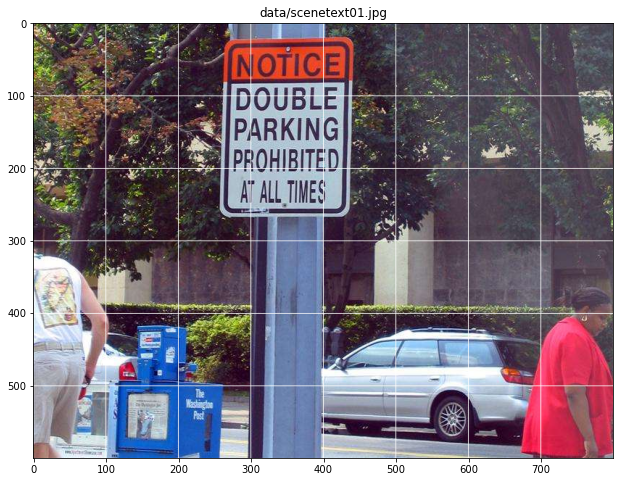

In [2]:
image_orig = cv2.imread('../data/scenetext01.jpg', cv2.IMREAD_COLOR)




######################################
print_image('data/scenetext01.jpg','image_orig',image_orig,300,305,100,107)
plt_view_image(plt,[["data/scenetext01.jpg", draw_grid(np.copy(image_orig),100,(255,255,255))[:,:,[2,1,0]]]],
               figsize=(16,8), axis='on', cmap='gray')

Initialize an **ORB** features detector. After this, detect the keypoints and compute the descriptors for the image. Then, draw the keypoints in the image:

Total Keypoints with nonmaxSuppression: 200 
kp.shape == (200, 2)
<KeyPoint 00000181EAABA990>
------  cv2.KeyPoint_convert-----    Shape(200, 2) kps: float32
[ 487.0 270.0 ]
[ 505.0 282.0 ]
[ 495.0 290.0 ]
[ 116.0 338.0 ]
[ 486.0 284.0 ]
[ 357.0 185.0 ]
31.0 67.24578857421875
31.0 63.752925872802734
31.0 50.870399475097656
31.0 88.43861389160156
31.0 244.12742614746094
31.0 255.83770751953125


<ipython-input-3-9dad7e8fdad4>:32: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(image_ORB, tuple(p), 4, (0, 255, 255), cv2.FILLED)


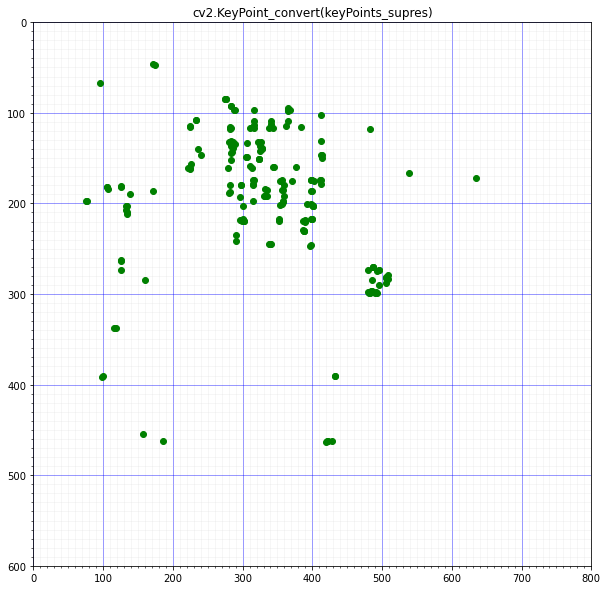

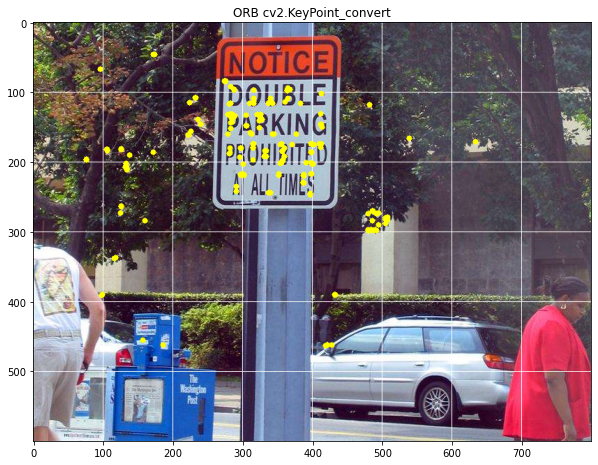

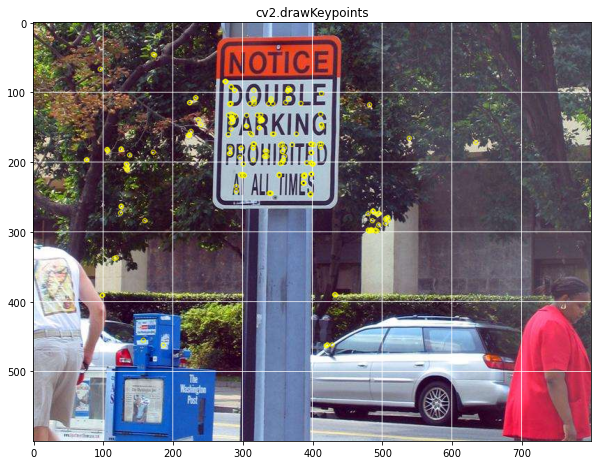

In [3]:
orb = cv2.ORB_create()
orb.setMaxFeatures(200)


ORB_keyPoints = orb.detect(image_orig, None)




#####################################################
print( "Total Keypoints with nonmaxSuppression: {0} ".format(len(ORB_keyPoints)) )
print('kp.shape ==',cv2.KeyPoint_convert(ORB_keyPoints).shape )
print(ORB_keyPoints[0])


#cv2.KeyPoint([x, y, _size[, _angle[, _response[, _octave[, _class_id]]]]]) → <KeyPoint object
# x – x-coordinate of the keypoint
# y – y-coordinate of the keypoint
# _pt – x & y coordinates of the keypoint
# _size – keypoint diameter
# _angle – keypoint orientation
# _response – keypoint detector response on the keypoint (that is, strength of the keypoint)
# _octave – pyramid octave in which the keypoint has been detected
# _class_id – object id

kps = cv2.KeyPoint_convert(ORB_keyPoints)
print_image('cv2.KeyPoint_convert','kps',kps,0,6,0,2)
for kp in ORB_keyPoints[:6]: print(kp.size, kp.angle)
    
image_ORB = draw_grid(np.copy(image_orig),100,(255,255,255))
for p in cv2.KeyPoint_convert(ORB_keyPoints):
    cv2.circle(image_ORB, tuple(p), 4, (0, 255, 255), cv2.FILLED)

image_drawKeypoints = cv2.drawKeypoints(draw_grid(np.copy(image_orig),100,(255,255,255)), 
                                        ORB_keyPoints, None, (0,255, 255))

##############################
plt.figure(figsize=(10,10))
plt_view_grid(plt, 'on',(0,800,0,600),(100,10,100,10),major_color='b')
plt.title('cv2.KeyPoint_convert(keyPoints_supres)')
plt.plot(kps[:,0],kps[:,1],'o', color="green")
plt.gca().invert_yaxis()
plt.show()

plt_view_image(plt,[["ORB cv2.KeyPoint_convert",image_ORB[:,:,[2,1,0]]]],
               figsize=(10,10), axis='on', cmap='gray')
plt_view_image(plt,[["cv2.drawKeypoints", image_drawKeypoints[:,:,[2,1,0]]]],
               figsize=(10,10), axis='on', cmap='gray')

------  data/scenetext01.jpg-----    Shape(200, 32) image_orig: uint8
[ 148 118 30 123 170 43 178 200 52 54 ]
[ 88 176 187 177 131 232 49 7 62 95 ]
[ 255 51 114 72 251 16 191 81 105 204 ]
Total Keypoints: 200 
kp.shape == (200, 2)
<KeyPoint 00000181D28D22A0>
------  cv2.KeyPoint_convert-----    Shape(200, 2) kps: float32
[ 487.0 270.0 ]
[ 505.0 282.0 ]
[ 495.0 290.0 ]
[ 116.0 338.0 ]
[ 486.0 284.0 ]
[ 357.0 185.0 ]
31.0 67.24578857421875
31.0 63.752925872802734
31.0 50.870399475097656
31.0 88.43861389160156
31.0 244.12742614746094
31.0 255.83770751953125


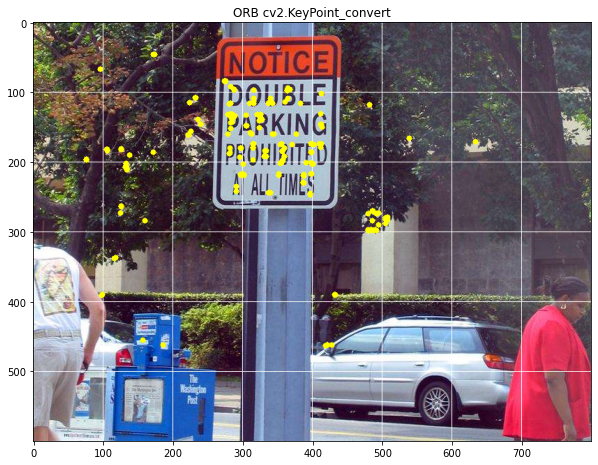

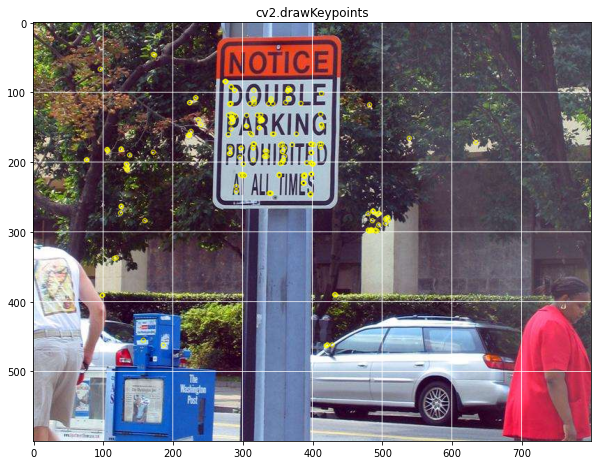

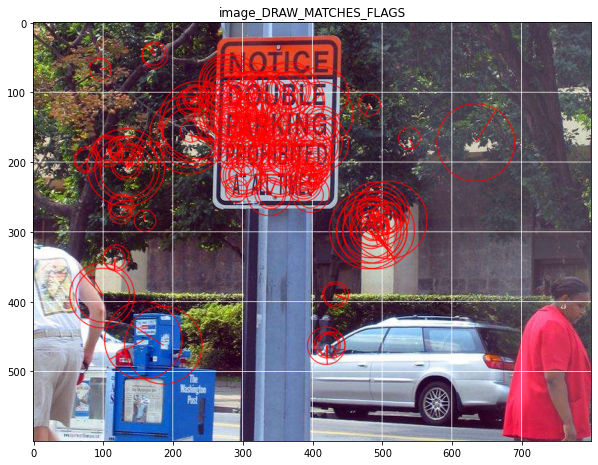

In [4]:
keyPoints_comp, descriptors = orb.compute(image_orig, ORB_keyPoints)

image_DRAW_MATCHES_FLAGS = cv2.drawKeypoints(draw_grid(np.copy(image_orig),100,(255,255,255)), 
                                             keyPoints_comp, None, (0, 0, 255), 
                                             cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)



#####################################################
print_image('data/scenetext01.jpg','image_orig',descriptors,0,3,0,10)

print( "Total Keypoints: {0} ".format(len(keyPoints_comp)) )
print('kp.shape ==',cv2.KeyPoint_convert(keyPoints_comp).shape )
print(keyPoints_comp[0])

kps = cv2.KeyPoint_convert(keyPoints_comp)
print_image('cv2.KeyPoint_convert','kps',kps,0,6,0,2)
for kp in keyPoints_comp[:6]: print(kp.size, kp.angle)
    
plt_view_image(plt,[["ORB cv2.KeyPoint_convert",image_ORB[:,:,[2,1,0]]]],
               figsize=(10,10), axis='on', cmap='gray')
plt_view_image(plt,[["cv2.drawKeypoints", image_drawKeypoints[:,:,[2,1,0]]]],
               figsize=(10,10), axis='on', cmap='gray')
plt_view_image(plt,[["image_DRAW_MATCHES_FLAGS", image_DRAW_MATCHES_FLAGS[:,:,[2,1,0]]]],
               figsize=(10,10), axis='on', cmap='gray')

In [5]:
surf = cv2.xfeatures2d.SURF_create(10000)
surf.setExtended(True)
surf.setNOctaves(3)
surf.setNOctaveLayers(10)
surf.setUpright(False)

keyPoints, descriptors = surf.detectAndCompute(img, None)

show_img = cv2.drawKeypoints(img, keyPoints, None, (255, 0, 0), 
                             cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imshow('SURF descriptors', show_img)
cv2.waitKey()
cv2.destroyAllWindows()

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv_contrib\modules\xfeatures2d\src\surf.cpp:1029: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'


In [ ]:
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create(32, True)

keyPoints, descriptors = brief.compute(img, keyPoints)

show_img = cv2.drawKeypoints(img, keyPoints, None, (0, 255, 0), 
                             cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imshow('BRIEF descriptors', show_img)
cv2.waitKey()
cv2.destroyAllWindows()